## Fase 2, Propuestas de KPI's

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib.dates as mdates


import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

import warnings
warnings.filterwarnings("ignore")


In [2]:
crime = pd.read_csv('../data/processed/super_clena_crimes.csv')
inmu = pd.read_csv('../data/processed/Neighborhood_zhvi_clean_with_yoy.csv')
business = pd.read_csv('../data/processed/Business_clean.csv')

print(f'Columnas de crime: \n {crime.columns},\n shape: {crime.shape}')
print('\n')
print(f'Columnas de inmu: \n{inmu.columns},\n shape: {inmu.shape}')
print('\n')
print(f'Columnas de business: \n{business.columns},\n shape: {business.shape}')


Columnas de crime: 
 Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Crm Cd', 'Crm Cd Desc', 'Vict Age', 'Vict Sex',
       'Vict Descent', 'Premis Desc', 'LOCATION', 'LAT', 'LON', 'Tipo_Delito',
       'Año', 'geometry', 'Neighborhood'],
      dtype='object'),
 shape: (1007324, 20)


Columnas de inmu: 
Index(['RegionID', 'SizeRank', 'RegionName', 'date', 'Price', 'year', 'month',
       'YoY_change'],
      dtype='object'),
 shape: (29997, 8)


Columnas de business: 
Index(['Unnamed: 0', 'LOCATION ACCOUNT #', 'BUSINESS NAME', 'STREET ADDRESS',
       'CITY', 'ZIP CODE', 'NAICS', 'PRIMARY NAICS DESCRIPTION',
       'COUNCIL DISTRICT', 'LOCATION START DATE', 'LOCATION END DATE',
       'LOCATION', 'Latitude', 'Longitude', 'geometry', 'index_right',
       'neighborhoods', 'Year star', 'Year end', 'Month star', 'Month end'],
      dtype='object'),
 shape: (1046644, 21)


## KPI 1: Índice de Influencia Comercial sobre la Vivienda (IICV)

**Objetivo:**  
El IICV busca medir cómo la actividad comercial (densidad de negocios) en un vecindario influye en el precio mediano de la vivienda. Esto nos ayuda a entender si existe una relación que sugiera, por ejemplo, que los vecindarios con mayor dinamismo comercial tienden a tener precios de vivienda más altos o viceversa.

---

### Fórmulas

La densidad comercial por vecindario puede aproximarse como:

$$ C_b = \frac{N_b}{A_b} $$

Donde:

- \( $C_b$ \): Densidad comercial del vecindario.  
- \( $N_b$ \): Número total de negocios en el vecindario.  
- \( $A_b$ \): Área del vecindario (en km² o mi²).

Luego, el IICV se define como la correlación entre:

- \( $\hat{B}_n = (C_{b_1}, C_{b_2}, \dots, C_{b_k})$ \): Densidades comerciales por vecindario.  
- \( $\hat{V}_n = (P_{v_1}, P_{v_2}, \dots, P_{v_k})$ \): Precios medianos de vivienda por vecindario.

La fórmula final del KPI es:

$$ \text{IICV} = \text{Corr}(\hat{B}_n, \hat{V}_n) $$

---

### ¿Por qué se hace así?

- **Densidad comercial** (\( $\hat{B}_n$ \)): Refleja el nivel de actividad económica de una zona. Una mayor concentración de negocios puede significar más infraestructura, servicios y empleos.
- **Precio mediano de vivienda** (\( $\hat{V}_n$ \)): Es un valor más robusto que el promedio y evita que valores atípicos distorsionen el análisis.
- **Correlación**: Nos permite cuantificar si existe una relación (y de qué tipo) entre ambas variables. Este valor será nuestro KPI.

---

### Lógica en el DataFrame

1. Calcular la densidad comercial por vecindario (una vez que se tenga el dataset de negocios y el área de cada vecindario).
2. Obtener el precio mediano de vivienda por vecindario (esto ya está en `inmu`).
3. Unir ambos conjuntos de datos por `RegionName` o `Vecindario`.
4. Calcular la correlación usando `pearsonr` o `np.corrcoef`.


IICV (correlación): -0.227 — p-valor: 0.055


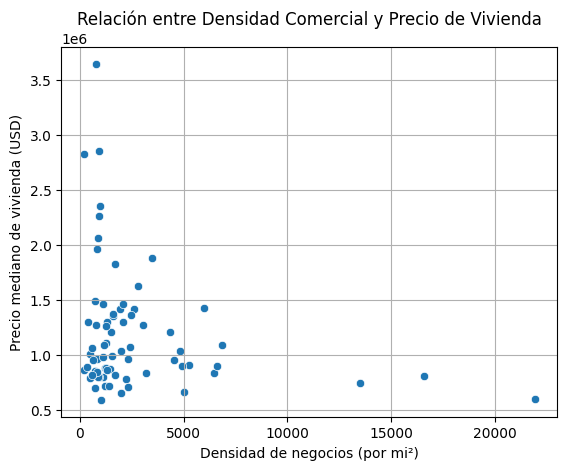

In [3]:
import geopandas as gpd

# URL del GeoJSON con geometría y área
geojson_url = "https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/eva_pereira_lahub_BA_24d4f6a092ee4506/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

# Leer los datos como GeoDataFrame
neigh_gdf = gpd.read_file(geojson_url)

# Extraer nombre del vecindario y su área (en metros cuadrados)
neigh_area_df = neigh_gdf[['name', 'Shape__Area']].copy()
neigh_area_df.rename(columns={'name': 'Neighborhood', 'Shape__Area': 'Area_m2'}, inplace=True)

# Convertir a millas cuadradas
neigh_area_df['Area_sqmi'] = neigh_area_df['Area_m2'] / 2.59e+6 # Conversión de m² a mi²


# business: tu dataset ya procesado, con columna 'neighborhoods'
negocios_por_vecindario = business.groupby('neighborhoods').size().reset_index(name='num_negocios')

# Unir con el área
densidad_df = negocios_por_vecindario.merge(
    neigh_area_df, left_on='neighborhoods', right_on='Neighborhood'
)

# Calcular densidad comercial
densidad_df['densidad_comercial'] = densidad_df['num_negocios'] / densidad_df['Area_sqmi']

# Asegurar que la columna de fecha sea datetime
inmu['date'] = pd.to_datetime(inmu['date'])

# Obtener el precio más reciente por vecindario
ultimos_precios = (
    inmu.sort_values('date')
        .groupby('RegionName')
        .tail(1)[['RegionName', 'Price']]
)

from scipy.stats import pearsonr

# Unir ambos DataFrames
df_kpi = densidad_df.merge(ultimos_precios, left_on='neighborhoods', right_on='RegionName')

# Calcular correlación (IICV)
iicv_valor, p_valor = pearsonr(df_kpi['densidad_comercial'], df_kpi['Price'])

print(f"IICV (correlación): {iicv_valor:.3f} — p-valor: {p_valor:.3f}")

# Gráficar la relación entre densidad comercial y precio de vivienda
sns.scatterplot(data=df_kpi, x='densidad_comercial', y='Price')
plt.title('Relación entre Densidad Comercial y Precio de Vivienda')
plt.xlabel('Densidad de negocios (por mi²)')
plt.ylabel('Precio mediano de vivienda (USD)')
plt.grid(True)
plt.show()

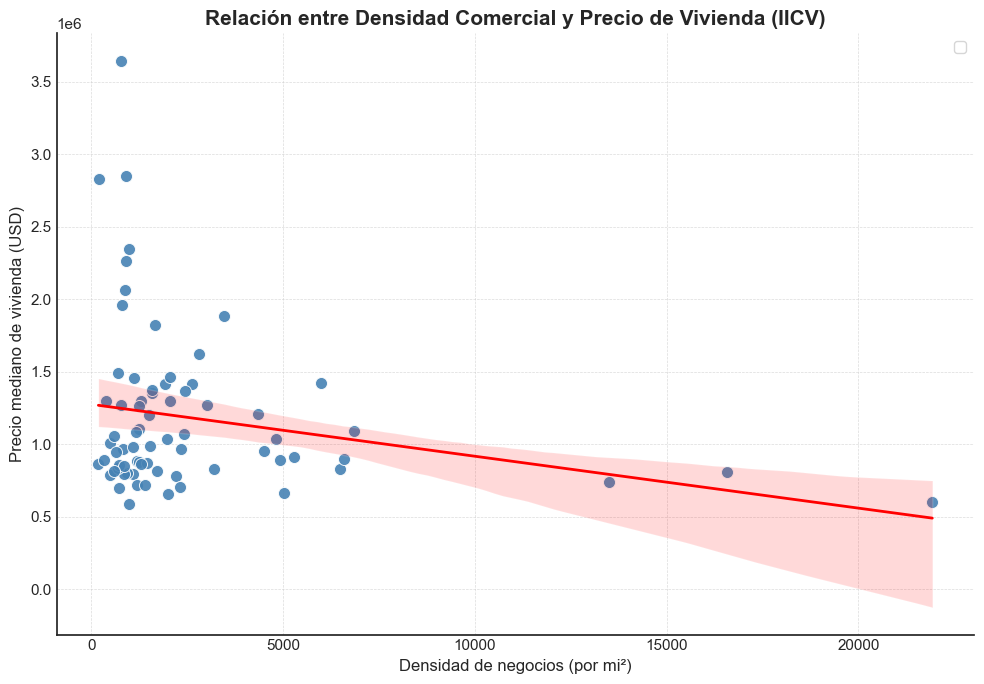

In [140]:
# Crear la figura y ajustar tamaño
plt.figure(figsize=(10, 7))

# Gráfico con puntos más suaves y color más atractivo
sns.scatterplot(
    data=df_kpi,
    x='densidad_comercial',
    y='Price',
    color='steelblue',
    marker='o',
    edgecolor='white',
    s=75,
    alpha=0.9
)

# Línea de tendencia con intervalo de confianza
sns.regplot(
    data=df_kpi,
    x='densidad_comercial',
    y='Price',
    scatter=False,
    color='red',
    line_kws={'linewidth': 2, 'label': 'Tendencia'},
    ci=95
)

# Títulos y etiquetas con formato profesional
plt.title('Relación entre Densidad Comercial y Precio de Vivienda (IICV)', fontsize=15, weight='bold')
plt.xlabel('Densidad de negocios (por mi²)', fontsize=12)
plt.ylabel('Precio mediano de vivienda (USD)', fontsize=12)

# Activar leyenda para línea de tendencia
plt.legend(loc='upper right', frameon=True)

# Estilo de cuadrícula
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

# Quitar bordes extra y mejorar presentación
sns.despine()

plt.tight_layout()
plt.show()

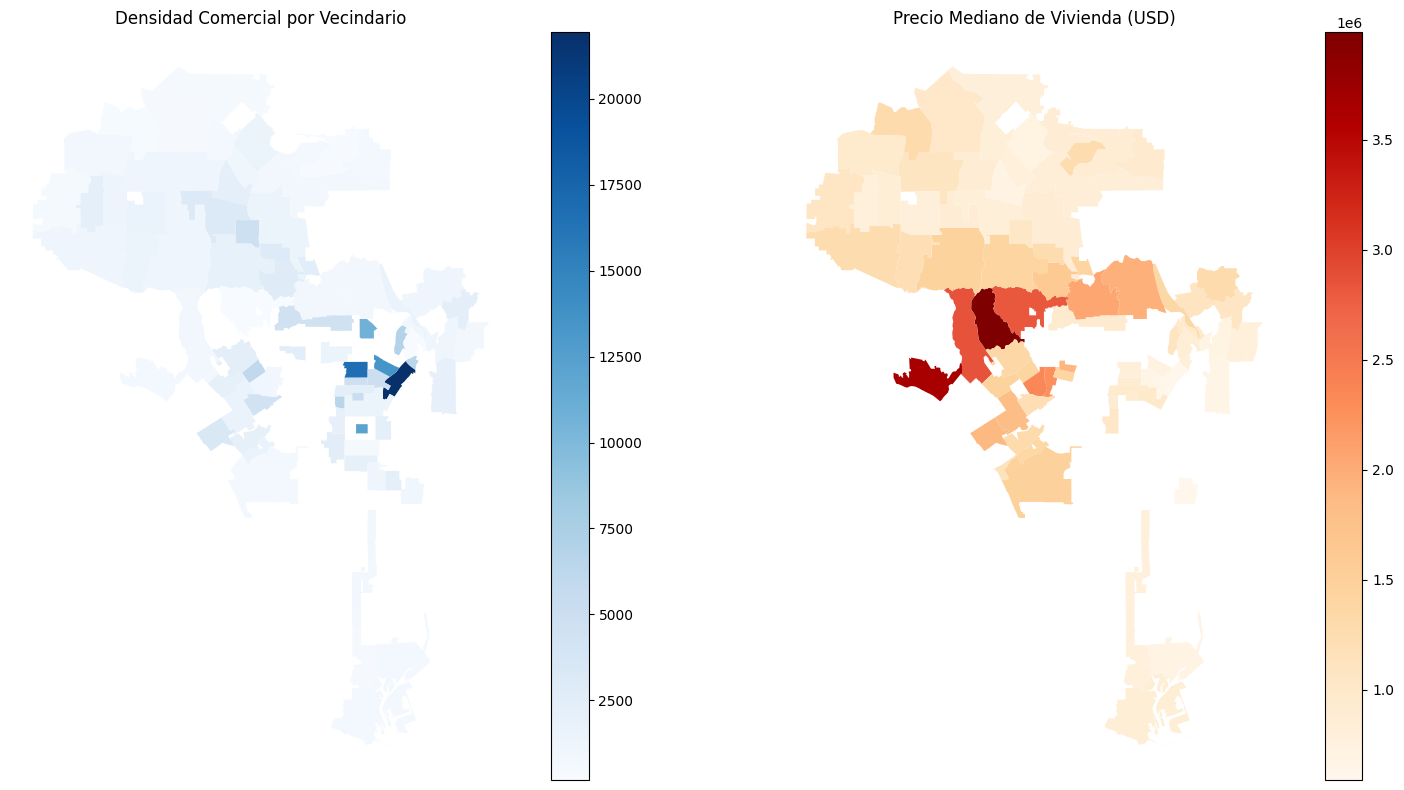

In [4]:
# Usamos el GeoDataFrame original
map_gdf = neigh_gdf[['name', 'geometry']].copy()
map_gdf.rename(columns={'name': 'Neighborhood'}, inplace=True)

# Unir con densidad comercial
map_gdf = map_gdf.merge(densidad_df[['Neighborhood', 'densidad_comercial']], on='Neighborhood', how='left')

# También puedes unir precios, si quieres
map_gdf = map_gdf.merge(ultimos_precios, left_on='Neighborhood', right_on='RegionName', how='left')

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Mapa 1: Densidad comercial
map_gdf.plot(column='densidad_comercial', cmap='Blues', legend=True, ax=ax[0])
ax[0].set_title("Densidad Comercial por Vecindario")

# Mapa 2: Precio de vivienda
map_gdf.plot(column='Price', cmap='OrRd', legend=True, ax=ax[1])
ax[1].set_title("Precio Mediano de Vivienda (USD)")

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()


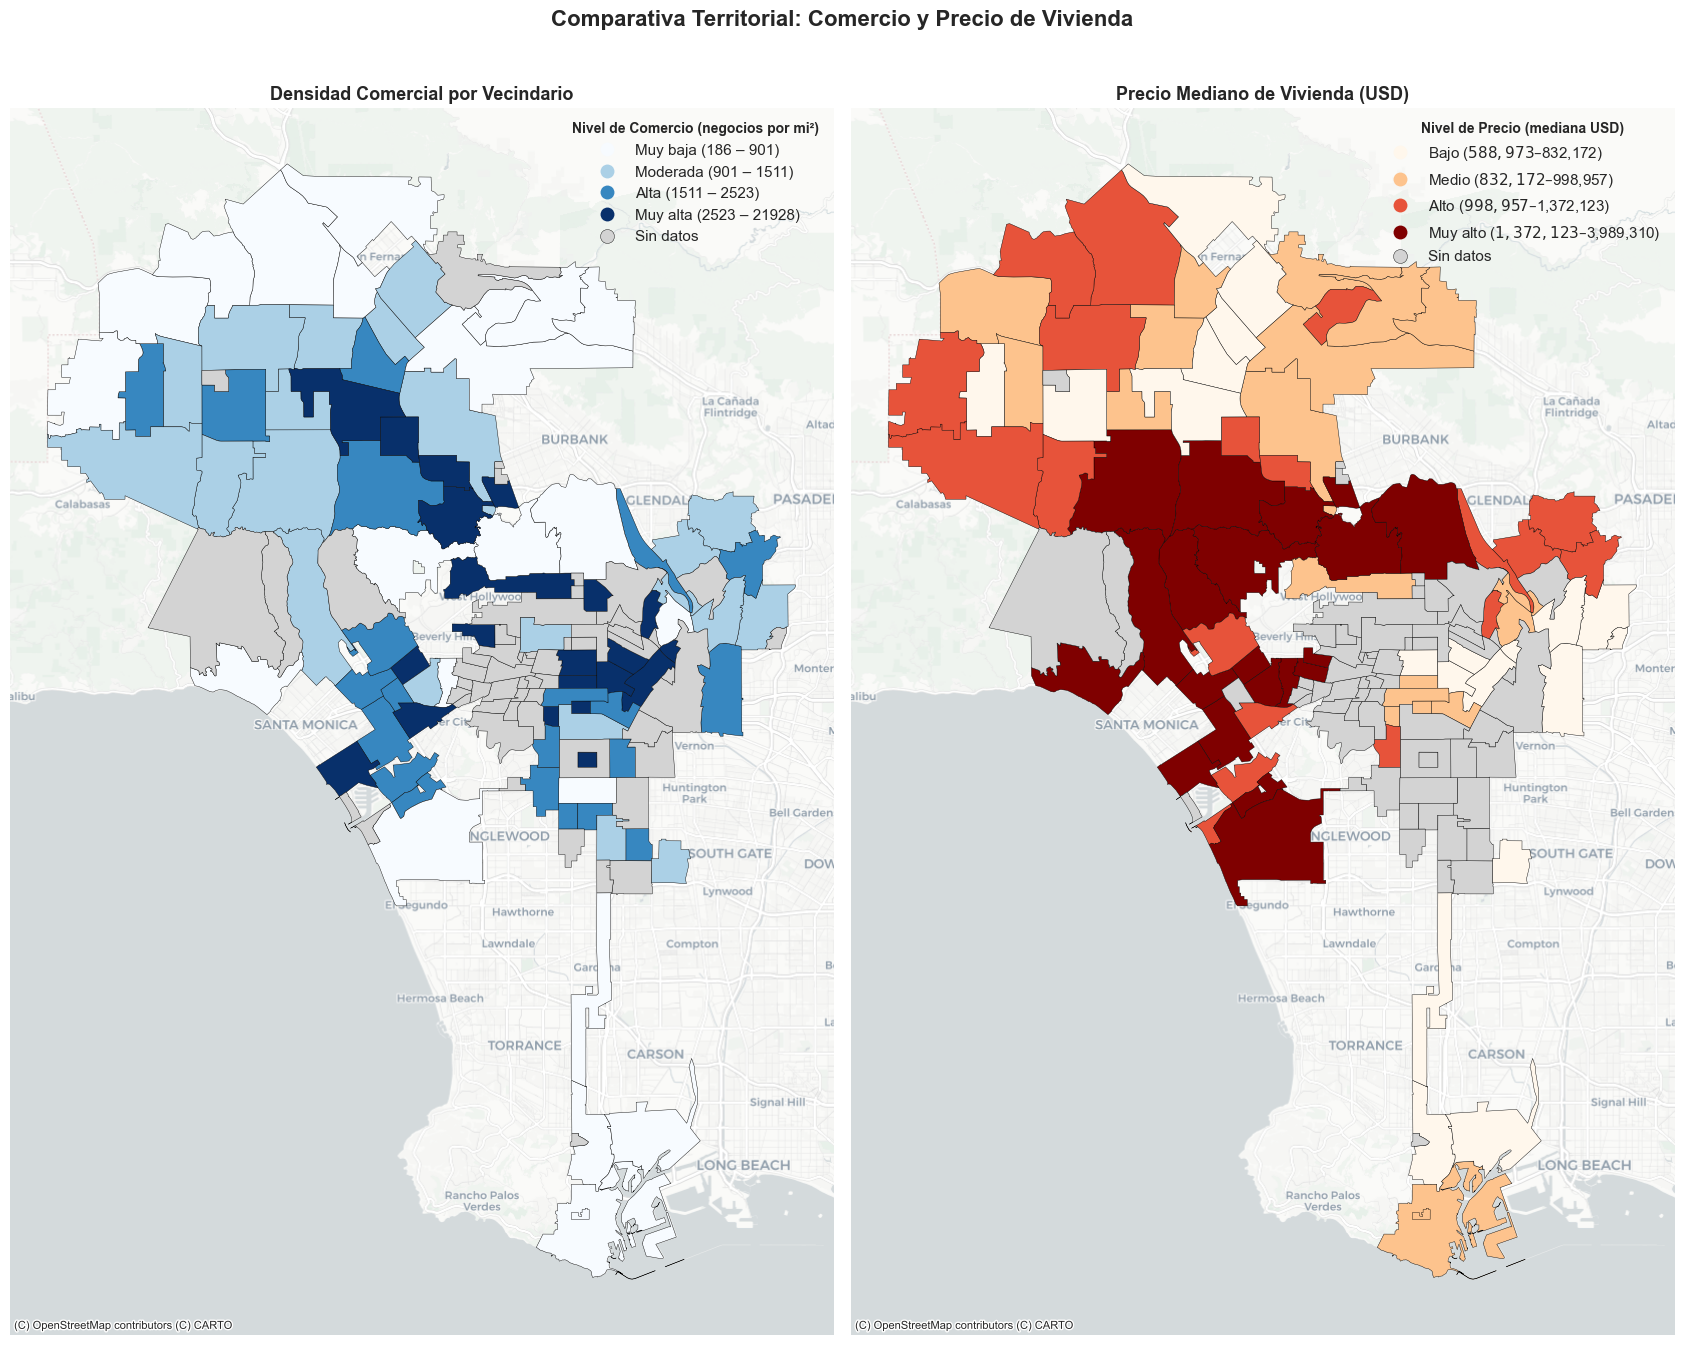

In [154]:
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify
import contextily as ctx

# 1. Crear copia base con geometría
map_gdf = neigh_gdf[['name', 'geometry']].copy()
map_gdf.rename(columns={'name': 'Neighborhood'}, inplace=True)

# 2. Unir con densidad comercial y precio mediano
map_gdf = map_gdf.merge(densidad_df[['Neighborhood', 'densidad_comercial']], on='Neighborhood', how='left')
map_gdf = map_gdf.merge(ultimos_precios, left_on='Neighborhood', right_on='RegionName', how='left')

# 3. Reproyectar
map_gdf = map_gdf.to_crs(epsg=3857)

# 4. Clasificadores cuantílicos para personalizar etiquetas
densidad_classifier = mapclassify.Quantiles(map_gdf['densidad_comercial'].dropna(), k=4)
precio_classifier = mapclassify.Quantiles(map_gdf['Price'].dropna(), k=4)

# 5. Crear figura
fig, ax = plt.subplots(1, 2, figsize=(17, 14))

# -------- Mapa 1: Densidad Comercial --------
map_gdf.plot(
    column='densidad_comercial',
    cmap='Blues',
    scheme='Quantiles',
    classification_kwds={'k': 4},
    legend=True,
    edgecolor='black',
    linewidth=0.3,
    ax=ax[0],
    missing_kwds={
        'color': 'lightgrey',
        'edgecolor': 'black',
        'label': 'Sin datos'
    }
)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Positron)
ax[0].set_title("Densidad Comercial por Vecindario", fontsize=13, weight='bold')
ax[0].axis('off')

# Etiquetas personalizadas densidad
leg_dens = ax[0].get_legend()
if leg_dens:
    leg_dens.set_title("Nivel de Comercio (negocios por mi²)", prop={'size': 10, 'weight': 'bold'})
    for i, text in enumerate(leg_dens.get_texts()):
        if ',' in text.get_text():
            l, r = text.get_text().replace("(", "").replace("]", "").split(",")
            etiquetas = ["Muy baja", "Moderada", "Alta", "Muy alta"]
            text.set_text(f"{etiquetas[i]} ({float(l):.0f} – {float(r):.0f})")
        elif "Sin datos" in text.get_text():
            text.set_text("Sin datos")

# -------- Mapa 2: Precio Mediano de Vivienda --------
map_gdf.plot(
    column='Price',
    cmap='OrRd',
    scheme='Quantiles',
    classification_kwds={'k': 4},
    legend=True,
    edgecolor='black',
    linewidth=0.3,
    ax=ax[1],
    missing_kwds={
        'color': 'lightgrey',
        'edgecolor': 'black',
        'label': 'Sin datos'
    }
)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Positron)
ax[1].set_title("Precio Mediano de Vivienda (USD)", fontsize=13, weight='bold')
ax[1].axis('off')

# Etiquetas personalizadas precio
leg_precio = ax[1].get_legend()
if leg_precio:
    leg_precio.set_title("Nivel de Precio (mediana USD)", prop={'size': 10, 'weight': 'bold'})
    for i, text in enumerate(leg_precio.get_texts()):
        if ',' in text.get_text():
            l, r = text.get_text().replace("(", "").replace("]", "").split(",")
            etiquetas = ["Bajo", "Medio", "Alto", "Muy alto"]
            text.set_text(f"{etiquetas[i]} (${int(float(l)):,} – ${int(float(r)):,})")
        elif "Sin datos" in text.get_text():
            text.set_text("Sin datos")

# -------- Título General --------
plt.suptitle("Comparativa Territorial: Comercio y Precio de Vivienda", fontsize=16, weight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


### Resultados del KPI 1 – Índice de Influencia Comercial sobre la Vivienda (IICV)

- **Valor del IICV (correlación):** -0.227
- **p-valor:** 0.055

---

### Interpretación estadística

- La correlación es **negativa y débil**: los vecindarios con mayor densidad comercial tienden a tener **precios de vivienda ligeramente más bajos**, aunque la relación no es fuerte.
- El **p-valor (0.055)** está ligeramente por encima del umbral de significancia estándar (0.05), lo cual significa que **no hay evidencia estadística suficiente** para afirmar con certeza esta relación.
- Aun así, el valor es **lo suficientemente cercano como para no descartarlo**. Puede tener valor exploratorio y merece un análisis más profundo o segmentado por zonas.

---

### Interpretación del scatter plot

- La mayoría de los vecindarios con alta densidad comercial tienen precios de vivienda bajos o intermedios.
- Algunos vecindarios con **precios de vivienda muy altos** tienen **baja densidad comercial**, lo que puede indicar zonas residenciales exclusivas con poca actividad económica.
- También se observan algunos **outliers** (zonas con densidad extremadamente alta o baja), que podrían explorarse por separado.

---

### Interpretación del mapa temático

- El **mapa de densidad comercial** muestra actividad concentrada en el centro y sur de Los Ángeles, coincidiendo con zonas más comerciales o industriales.
- El **mapa de precios de vivienda** destaca zonas del oeste y suroeste como las más caras (e.g., Santa Monica, Bel Air), que **no coinciden** con las zonas de mayor densidad comercial.
- Esto sugiere una **segmentación urbana**: zonas residenciales valiosas alejadas del bullicio comercial, y zonas comerciales con precios más accesibles.

---

### Conclusión general

> Aunque no se obtuvo una correlación estadísticamente significativa al 95%, el IICV sugiere que en Los Ángeles podría existir una **relación inversa moderada** entre actividad comercial y valor inmobiliario. Esto puede reflejar patrones de zonificación, planificación urbana o preferencias residenciales que **valoran la exclusividad y el bajo ruido comercial**.

Este resultado es un **insumo útil para el análisis urbano y de desarrollo económico local**, aunque debe ser complementado con otros indicadores.


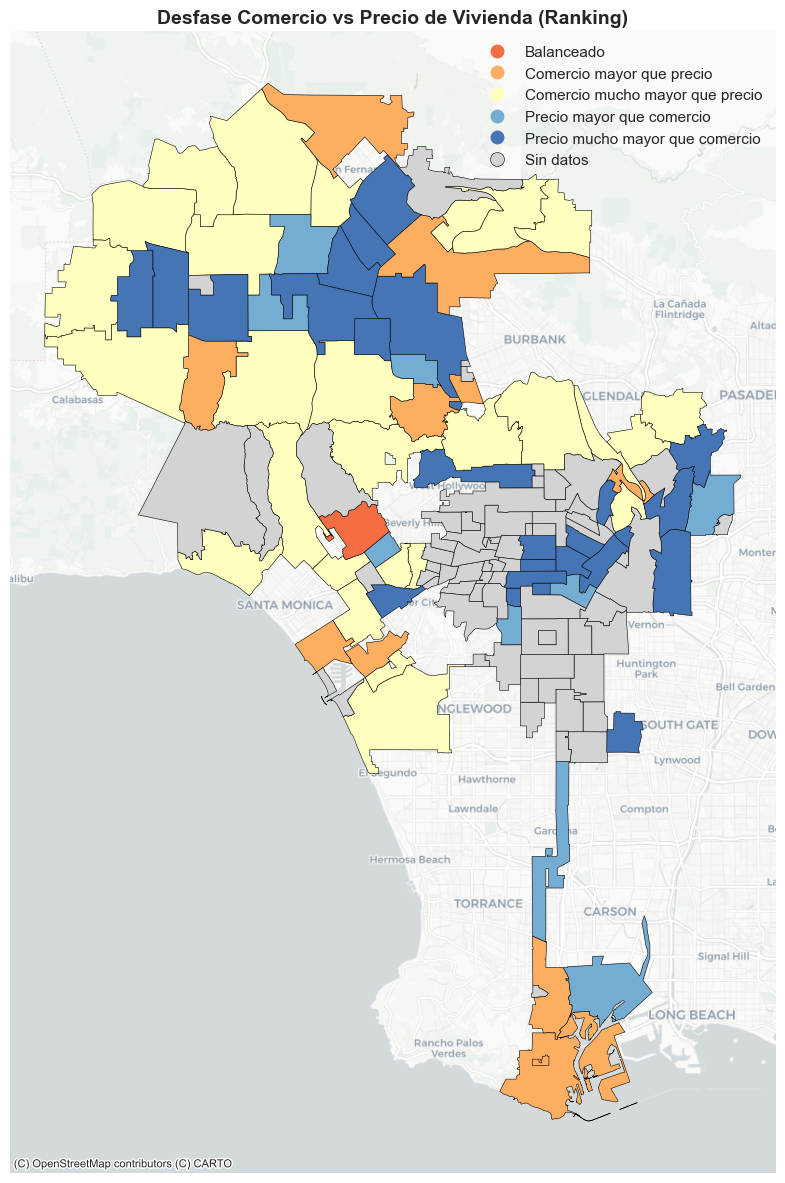

In [ ]:
# Asegurarse de trabajar sobre un GeoDataFrame limpio
map_gdf_clean = map_gdf.copy()

# Filtrar para evitar errores con valores nulos
map_gdf_valid = map_gdf_clean.dropna(subset=['densidad_comercial', 'Price']).copy()

# Calcular rankings (orden descendente: mayor valor = mejor ranking)
map_gdf_valid['rank_densidad'] = map_gdf_valid['densidad_comercial'].rank(ascending=False)
map_gdf_valid['rank_precio'] = map_gdf_valid['Price'].rank(ascending=False)

# Diferencia de ranking: positivo = más comercio que precio
map_gdf_valid['diff_rank'] = map_gdf_valid['rank_densidad'] - map_gdf_valid['rank_precio']

# Clasificación cualitativa
def clasificar_diferencia(x):
    if pd.isna(x):
        return "Sin datos"
    elif x >= 10:
        return "Comercio mucho mayor que precio"
    elif x >= 3:
        return "Comercio mayor que precio"
    elif x > -3:
        return "Balanceado"
    elif x > -10:
        return "Precio mayor que comercio"
    else:
        return "Precio mucho mayor que comercio"

map_gdf_valid['diff_cat'] = map_gdf_valid['diff_rank'].apply(clasificar_diferencia)

# Insertar columna categórica al GeoDataFrame original (para que los sin datos aparezcan)
map_gdf_clean = map_gdf_clean.merge(
    map_gdf_valid[['Neighborhood', 'diff_cat']],
    on='Neighborhood',
    how='left'
)

# Reproyectar para fondo de mapa
map_gdf_clean = map_gdf_clean.to_crs(epsg=3857)

# Colores manuales para las categorías
colores = {
    "Comercio mucho mayor que precio": "#f46d43",
    "Comercio mayor que precio": "#fdae61",
    "Balanceado": "#ffffbf",
    "Precio mayor que comercio": "#74add1",
    "Precio mucho mayor que comercio": "#4575b4",
    "Sin datos": "lightgrey"
}

# Graficar el mapa categorizado
fig, ax = plt.subplots(figsize=(10, 12))
map_gdf_clean.plot(
    column='diff_cat',
    ax=ax,
    legend=True,
    edgecolor='black',
    linewidth=0.4,
    cmap=plt.matplotlib.colors.ListedColormap([colores[c] for c in colores if c != "Sin datos"]),
    categorical=True,
    missing_kwds={
        'color': colores["Sin datos"],
        'edgecolor': 'black',
        'label': 'Sin datos'
    }
)

# Mapa base
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Estética del mapa
ax.set_title("Desfase Comercio vs Precio de Vivienda (Ranking)", fontsize=14, weight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()


## KPI 2: Índice de Seguridad Comercial (ISC)

**Objetivo:**  
El ISC evalúa si existe una relación entre la **criminalidad** de un vecindario y su **densidad comercial**. Se busca determinar si los vecindarios con más negocios tienden a tener más o menos delitos, permitiendo así identificar zonas de alto riesgo o con oportunidad de desarrollo seguro.

---

### Fórmulas

La **tasa de criminalidad por vecindario** se puede calcular como:

$$ T_{Cr_n} = \frac{\sum_{i=1}^{p} c_i}{P_n} $$

Donde:

- \( $T_{Cr_n}$ \): Tasa de criminalidad del vecindario \( $n$ \)  
- \( $c_i$ \): Número de crímenes en la unidad \( $i$ \) dentro del vecindario  
- \( $P_n$ \): Población total del vecindario \( $n$ \)

Los vectores que se comparan para calcular el KPI son:

- \( $\hat{T}_{Cr_n} = (T_{Cr_1}, T_{Cr_2}, \dots, T_{Cr_k})$ \): Tasas de criminalidad por vecindario  
- \( $\hat{B}_n = (C_{b_1}, C_{b_2}, \dots, C_{b_k})$ \): Densidades comerciales por vecindario

La fórmula del ISC es:

$$ \text{ISC} = \text{Corr}(\hat{T}_{Cr_n}, \hat{B}_n) $$

---

### Lógica de implementación

1. **Tasa de criminalidad por vecindario:**  
   - Agrupar `crime` por `Vecindario` y contar el número de delitos.  
   - Dividir ese total por la población del vecindario desde el archivo `census_population_clean.csv`.

2. **Densidad comercial por vecindario:**  
   - Se contará el número de negocios por vecindario (cuando se tenga ese dataset).  
   - Se podrá normalizar por área o población, dependiendo de la interpretación.

3. **Unión de ambos conjuntos** por vecindario (`Vecindario` o `RegionName`).

4. **Cálculo de la correlación** usando Pearson (`scipy.stats.pearsonr`) o `pandas.corr()`.

---



####  Población ---- con API

In [5]:
# Leer desde la API de población por vecindario
url_poblacion = "https://data.lacity.org/resource/nwj3-ufba.json"
pop = pd.read_json(url_poblacion)

# Renombrar columnas para claridad
pop = pop.rename(columns={
    'nc_name': 'Neighborhood',
    'population_2012': 'Total_Population'
})

# Limpiar nombres para que coincidan con los de crime o eso esperamos
pop['Neighborhood_clean'] = pop['Neighborhood'].str.lower().str.strip()


pop.head()

Neighborhood  Total_Population  white_pop  black_pop  \
0                 ARLETA NC          34932.84    2882.67     409.67   
1            ARROYO SECO NC          21711.47    4640.35     782.76   
2        ATWATER VILLAGE NC          11385.40    3450.70     127.80   
3  BEL AIR-BEVERLY CREST NC          26789.14   22024.61     349.63   
4          BOYLE HEIGHTS NC          81900.56    1562.20     640.97   

   ameri_es_pop  asian_pop  hawn_pi_pop  other_pop  multi_pop    vacant  \
0         67.64    4061.31        34.96      37.58     245.05  34700.56   
1         89.51    3215.37        25.38      66.98     263.12  21582.85   
2          0.15    2379.08        71.85       0.37     252.76  11345.53   
3          0.02    1787.79         0.01     156.92     946.28  26623.97   
4         63.63    2266.59        73.99      90.30      98.50  81144.31   

   owner_occ  renter_occ        Neighborhood_clean  
0    5590.27     2159.94                 arleta nc  
1    4138.14     3235.61            arroyo seco nc  
2    1877.30     2902.89        atwater village nc  
3    8939.21     1943.18  bel air-beverly crest nc  
4    4743.28    16001.77          boyle heights nc

In [6]:
print(f' shape: {pop.shape}\n nombres columnas: {pop.columns},\n tipos: {pop.dtypes}')

 shape: (97, 13)
 nombres columnas: Index(['Neighborhood', 'Total_Population', 'white_pop', 'black_pop',
       'ameri_es_pop', 'asian_pop', 'hawn_pi_pop', 'other_pop', 'multi_pop',
       'vacant', 'owner_occ', 'renter_occ', 'Neighborhood_clean'],
      dtype='object'),
 tipos: Neighborhood           object
Total_Population      float64
white_pop             float64
black_pop             float64
ameri_es_pop          float64
asian_pop             float64
hawn_pi_pop           float64
other_pop             float64
multi_pop             float64
vacant                float64
owner_occ             float64
renter_occ            float64
Neighborhood_clean     object
dtype: object


In [7]:
# -------------------------
# 1. Cargar población desde API
# -------------------------
url_poblacion = "https://data.lacity.org/resource/nwj3-ufba.json"
pop = pd.read_json(url_poblacion)

# Renombrar columnas clave
pop = pop.rename(columns={
    'nc_name': 'Neighborhood',
    'population_2012': 'Total_Population'
})

# Limpiar nombres
pop['Neighborhood_clean'] = pop['Neighborhood'].str.lower().str.strip()

# -------------------------
# 2. Agrupar delitos por vecindario
# -------------------------
# Asegúrate que crime['Neighborhood'] existe y está limpia
crime['Neighborhood_clean'] = crime['Neighborhood'].str.lower().str.strip()

crimenes_por_vecindario = (
    crime.groupby('Neighborhood_clean')
    .size()
    .reset_index(name='num_crimenes')
)

# -------------------------
# 3. Calcular tasa de criminalidad
# -------------------------
# Unir crímenes + población
tasa_crimen_df = crimenes_por_vecindario.merge(
    pop[['Neighborhood_clean', 'Total_Population']],
    on='Neighborhood_clean',
    how='inner'
)

# Calcular tasa
tasa_crimen_df['tasa_criminalidad'] = (
    tasa_crimen_df['num_crimenes'] / tasa_crimen_df['Total_Population']
)

# -------------------------
# 4. Unir con densidad comercial (de KPI 1)
# -------------------------
# Aseguramos consistencia de nombres
densidad_df['Neighborhood_clean'] = densidad_df['Neighborhood'].str.lower().str.strip()

isc_df = tasa_crimen_df.merge(
    densidad_df[['Neighborhood_clean', 'densidad_comercial']],
    on='Neighborhood_clean',
    how='inner'
)

# -------------------------
# 5. Calcular KPI – ISC
# -------------------------
isc_valor, p_valor = pearsonr(
    isc_df['tasa_criminalidad'],
    isc_df['densidad_comercial']
)

print(f"ISC (correlación): {isc_valor:.3f} — p-valor: {p_valor:.3f}")

ValueError: `x` and `y` must have length at least 2.

In [8]:
print(f"Tamaño de tasa_crimen_df: {tasa_crimen_df.shape}")
print(f"Tamaño de densidad_df: {densidad_df.shape}")
print(f"Tamaño de isc_df (unión final): {isc_df.shape}")
print(isc_df[['Neighborhood_clean', 'tasa_criminalidad', 'densidad_comercial']].head())


Tamaño de tasa_crimen_df: (0, 4)
Tamaño de densidad_df: (85, 7)
Tamaño de isc_df (unión final): (0, 5)
Empty DataFrame
Columns: [Neighborhood_clean, tasa_criminalidad, densidad_comercial]
Index: []


In [9]:
print("Vecindarios en población pero no en crimen:")
print(set(pop['Neighborhood_clean']) - set(crime['Neighborhood_clean']))

print("\nVecindarios en crimen pero no en población:")
print(set(crime['Neighborhood_clean']) - set(pop['Neighborhood_clean']))


Vecindarios en población pero no en crimen:
{'sylmar nc', 'empowerment congress southeast area ndc', 'greater wilshire nc', 'mission hills nc', 'west adams nc', 'pacoima nc', 'bel air-beverly crest nc', 'community and neighbors for ninth district unity (canndu)', 'p.i.c.o. nc', 'westwood nc', 'northwest san pedro nc', 'nc valley village', 'granada hills north nc', 'granada hills south nc', 'westlake south nc', 'silver lake nc', 'empowerment congress north area ndc', 'sherman oaks nc', 'sunland-tujunga nc', 'voices of 90037', 'northridge south nc', 'central alameda nc', 'atwater village nc', 'palms nc', 'sun valley area nc', 'eagle rock nc', 'arroyo seco nc', 'park mesa heights cc', 'lake balboa nc', 'noho west nc', 'del rey nc', 'northridge west', 'wilshire center - koreatown nc', 'hermon nc', 'mid city west cc', 'mid-town north hollywood nc', 'central hollywood nc', 'greater echo park elysian nc', 'west los angeles nc', 'panorama city nc', 'lincoln heights nc', 'boyle heights nc', 'no

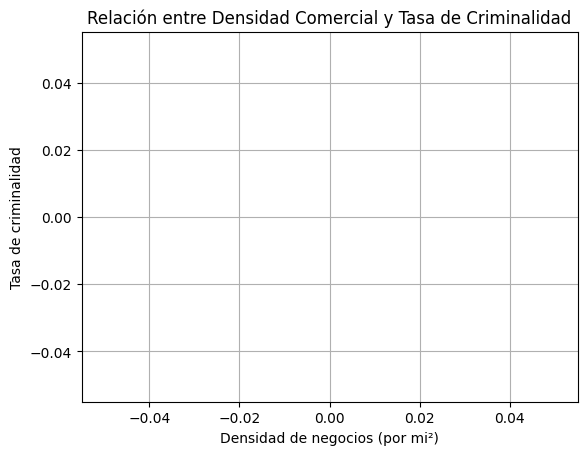

In [10]:
# Gráfico de dispersión
sns.scatterplot(
    data=isc_df,
    x='densidad_comercial',
    y='tasa_criminalidad'
)
plt.title('Relación entre Densidad Comercial y Tasa de Criminalidad')
plt.xlabel('Densidad de negocios (por mi²)')
plt.ylabel('Tasa de criminalidad')
plt.grid(True)
plt.show()


In [11]:
pop.to_csv('../data/processed/population.csv', index=False)

### Calculo


## KPI 3: Índice de Sensibilidad del Valor Inmobiliario a la Seguridad (ISV)

### Objetivo

Este indicador busca evaluar **cómo influye el cambio en la criminalidad sobre el cambio en el precio de la vivienda**. Nos permite analizar si los incrementos o reducciones en la inseguridad se reflejan directamente en el comportamiento del mercado inmobiliario a nivel vecindario.

---

### Fórmulas

**Cambio porcentual de criminalidad por periodo** (mes o año):

$$ d_c = \frac{C_t}{C_{t-1}} - 1 $$

Donde:

- \( $C_t$ \): Número total de crímenes en el periodo \( $t$ \)
- \( $C_{t-1}$ \): Número total de crímenes en el periodo anterior

---

**Cambio porcentual del precio mediano de la vivienda**:

$$ d_p = \frac{P_t}{P_{t-1}} - 1 $$

Donde:

- \( $P_t$ \): Precio mediano de la vivienda en el periodo \( $t$ \)
- \( $P_{t-1}$ \): Precio mediano del periodo anterior

---

### Índice de Sensibilidad del Valor Inmobiliario a la Seguridad:

Se define como la **correlación entre el cambio porcentual de criminalidad y el cambio porcentual del precio inmobiliario**, por vecindario:

$$ \text{ISV} = \text{Corr}(d_c, d_p) $$

---

### Lógica de implementación

1. Agrupar el dataset de **crimen** por `Vecindario_Oficial` y `Mes/Año` para obtener \( $C_t$ \).
2. Calcular el **cambio porcentual mensual** en crímenes \( d_c \) por vecindario.
3. Agrupar el dataset de **vivienda** (`inmu`) por `RegionName` y `date` para obtener \( $P_t$ \).
4. Calcular el **cambio porcentual mensual** del precio \( d_p \) por vecindario.
5. Unir ambos datasets por `vecindario` y `fecha`.
6. Calcular la **correlación** entre las columnas `d_c` y `d_p` para cada vecindario.
7. Analizar si existe una relación significativa (positiva o negativa) entre los cambios.

---

### Interpretación

- Un valor **positivo** del ISV sugiere que **más crimen = precios más altos** (inusual, pero posible en zonas gentrificadas).
- Un valor **negativo** del ISV sugiere que **más crimen = precios más bajos**, lo cual es común en muchas áreas.
- Un valor cercano a **cero** indica **falta de relación directa** entre las variables en ese vecindario.



In [113]:
# =========================
# 1. Procesar crimen mensual
# =========================

# Asegurar formato datetime
crime['DATE OCC'] = pd.to_datetime(crime['DATE OCC'])
# Extraer el mes (periodo mensual) y estandarizar nombre de vecindario
crime['mes'] = crime['DATE OCC'].dt.to_period('M')
crime['Neighborhood_crimen'] = crime['Neighborhood'].str.lower().str.strip()

# Agrupar: número de crímenes por mes y vecindario
crimen_mensual = (
    crime.groupby(['Neighborhood_crimen', 'mes'])
    .size()
    .reset_index(name='total_crimenes')
)

# Cambio porcentual mensual por vecindario  para mayor claridad pasara de dc a variacion crimen
crimen_mensual['mes'] = crimen_mensual['mes'].astype(str)  # para merge con inmu luego
crimen_mensual['variacion_crimen'] = crimen_mensual.groupby('Neighborhood_crimen')['total_crimenes'].pct_change()

In [114]:
# ============================
# 2. Procesar precios de vivienda
# ============================

# Precios de vivienda por mes, limpiar nombres y convertir fechas
inmu['date'] = pd.to_datetime(inmu['date'])
inmu['mes'] = inmu['date'].dt.to_period('M').astype(str)
inmu['RegionName_vivienda'] = inmu['RegionName'].str.lower().str.strip()

# Precio mediano mensual por vecindario
precio_mensual = (
    inmu.groupby(['RegionName_vivienda', 'mes'])['Price']
    .median()
    .reset_index(name='precio_median_mensual')
)

# Cambio porcentual mensual por vecindario, igual dp pasara a variacion precio
precio_mensual['variacion_precio'] = precio_mensual.groupby('RegionName_vivienda')['precio_median_mensual'].pct_change()

In [115]:
# ============================
# 3. Unir crimen + vivienda por vecindario y mes
# ============================

isv_df = crimen_mensual.merge(
    precio_mensual,
    left_on=['Neighborhood_crimen', 'mes'],
    right_on=['RegionName_vivienda', 'mes'],
    how='inner'
)

# Filtrar NaN o valores extremos, para que no afecten la correlación global
isv_df = isv_df.dropna(subset=['variacion_crimen', 'variacion_precio'])


In [116]:
print(f'Nulos:\n{isv_df.isnull().sum()}')

Nulos:
Neighborhood_crimen      0
mes                      0
total_crimenes           0
variacion_crimen         0
RegionName_vivienda      0
precio_median_mensual    0
variacion_precio         0
dtype: int64


In [117]:
# ============================
# 4. Calcular ISV Global
# ============================
# ISV total (todas las observaciones combinadas)
isv_valor, p_valor = pearsonr(isv_df['variacion_crimen'], isv_df['variacion_precio'])
print(f"ISV global: {isv_valor:.3f} — p-valor: {p_valor:.3f}\n")


# ============================
# 5. Calcular ISV por vecindario
# ============================


# ISV por vecindario
isv_por_vecindario = (
    isv_df.groupby('Neighborhood_crimen')[['variacion_crimen', 'variacion_precio']]
    .corr()
    .iloc[0::2, -1]  # extrae correlaciones entre columnas, filtrar solo correlación d_c vs d_p
    .reset_index()
    .rename(columns={'level_1': 'tipo', 'variacion_precio': 'ISV'})
    .query("tipo == 'variacion_crimen'")
)

print(f'ISV por vecindario:\n{isv_por_vecindario.head(10)}')

ISV global: 0.073 — p-valor: 0.000

ISV por vecindario:
  Neighborhood_crimen              tipo       ISV
0     adams-normandie  variacion_crimen  0.075070
1              arleta  variacion_crimen  0.114216
2   arlington heights  variacion_crimen  0.155105
3     atwater village  variacion_crimen  0.122764
4       beverly crest  variacion_crimen  0.169731
5         beverlywood  variacion_crimen -0.076720
6       boyle heights  variacion_crimen  0.053773
7           brentwood  variacion_crimen  0.152381
8         canoga park  variacion_crimen  0.104300
9        century city  variacion_crimen  0.023858


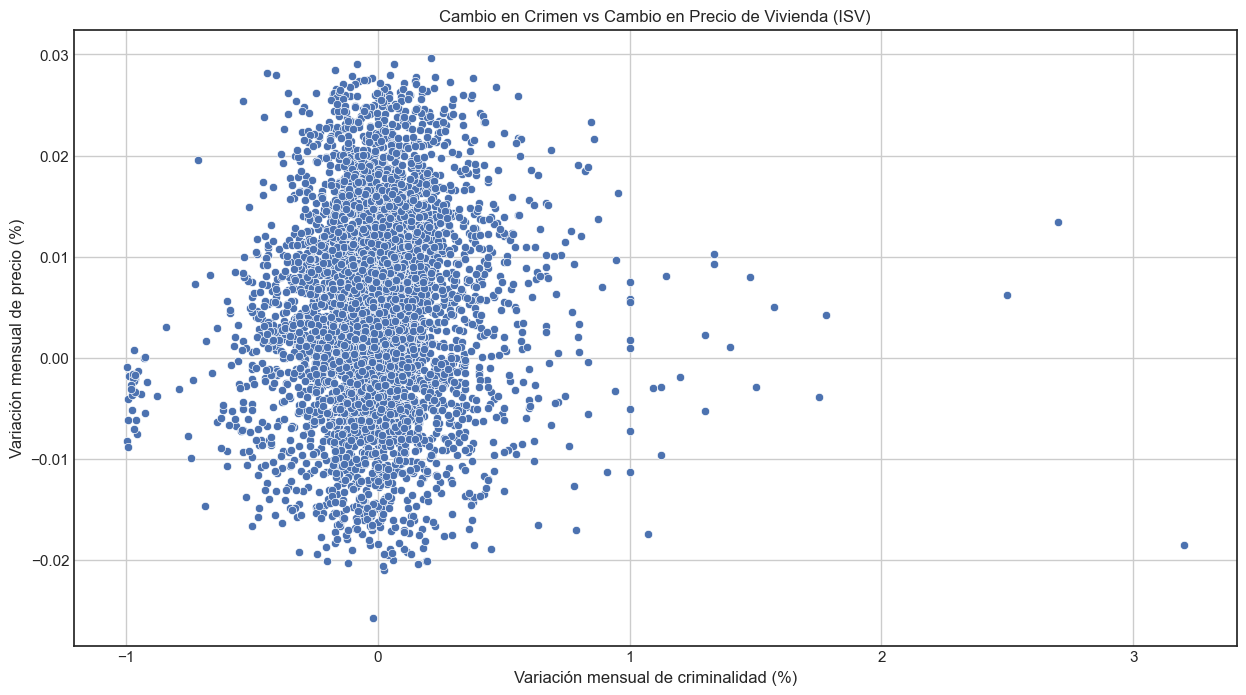

In [118]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(data=isv_df, x='variacion_crimen', y='variacion_precio')
plt.title('Cambio en Crimen vs Cambio en Precio de Vivienda (ISV)')
plt.xlabel('Variación mensual de criminalidad (%)')
plt.ylabel('Variación mensual de precio (%)')
plt.grid(True)
plt.show()

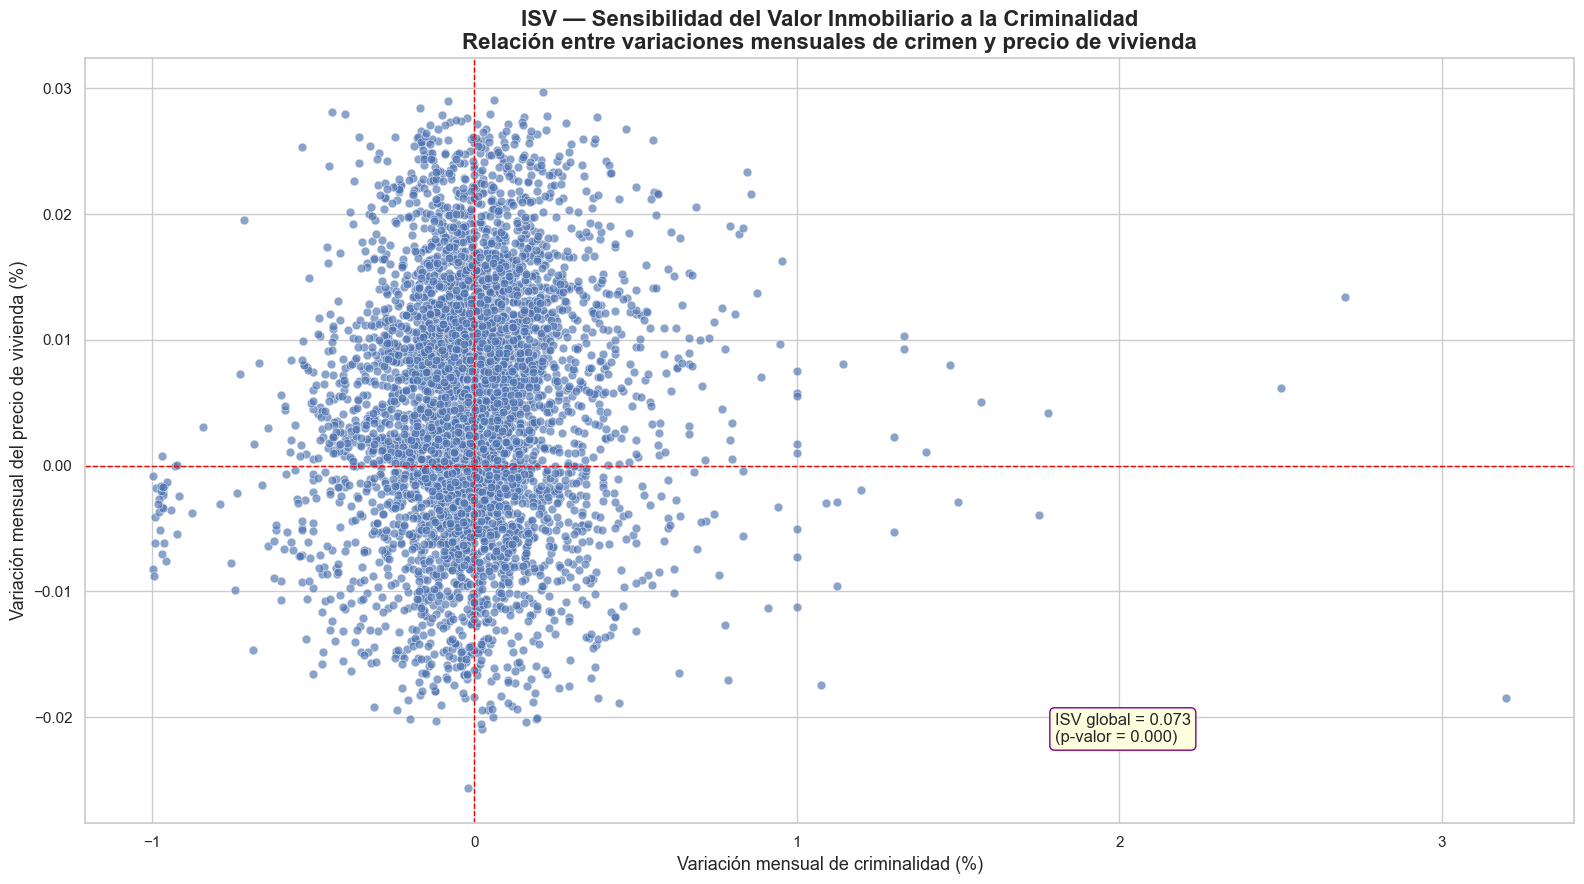

In [119]:
# Gráfico principal
plt.figure(figsize=(16, 9))
sns.set(style="whitegrid")

# Scatterplot
sns.scatterplot(
    data=isv_df,
    x='variacion_crimen',
    y='variacion_precio',
    alpha=0.65,
    s=40,
    edgecolor='w',
    linewidth=0.5
)

# Títulos y ejes
plt.title('ISV — Sensibilidad del Valor Inmobiliario a la Criminalidad\nRelación entre variaciones mensuales de crimen y precio de vivienda', fontsize=16, weight='bold')
plt.xlabel('Variación mensual de criminalidad (%)', fontsize=13)
plt.ylabel('Variación mensual del precio de vivienda (%)', fontsize=13)

# Líneas guía
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='red', linestyle='--', linewidth=1)

# Anotación del valor del ISV Global
plt.text(
    x=1.8, y=-0.022, 
    s=f"ISV global = {isv_valor:.3f}\n(p-valor = {p_valor:.3f})",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", edgecolor="purple")
)

plt.tight_layout()
plt.show()


#### Gráfico de Dispersión — ISV Global

Este gráfico muestra la relación entre las **variaciones mensuales de criminalidad** (eje X) y las **variaciones mensuales del precio de vivienda** (eje Y) en todos los vecindarios de Los Ángeles.

- Cada punto representa un mes en un vecindario.
- Las líneas punteadas rojas marcan el eje cero en ambas variables.
- La anotación muestra el valor **ISV global = 0.073**, estadísticamente significativo (**p-valor = 0.000**).

Aunque la mayoría de los puntos se concentran cerca del origen, se observan algunos outliers, lo que sugiere que hay vecindarios donde los cambios de crimen podrían tener efecto más marcado en los precios.


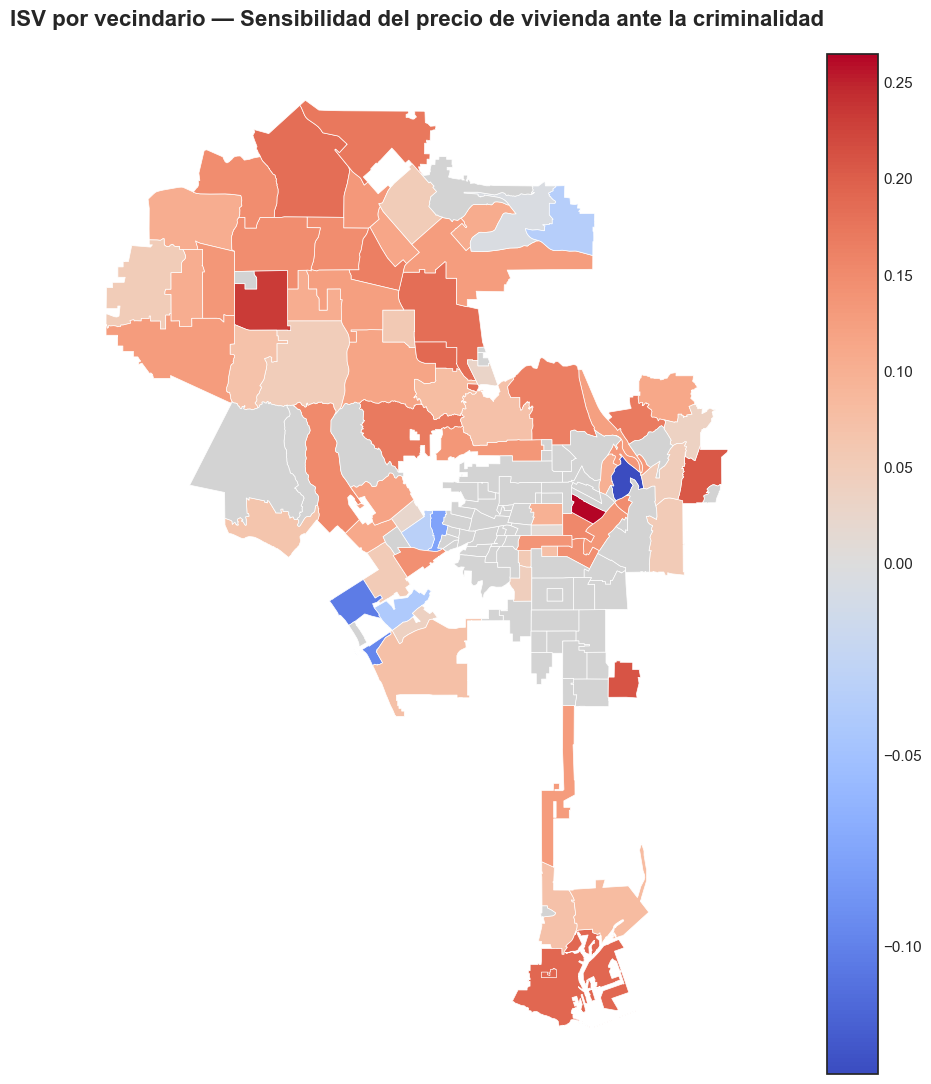

In [120]:
# Cargar el GeoJSON (ya usado antes en KPI 1)
geojson_url = "https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/eva_pereira_lahub_BA_24d4f6a092ee4506/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
vecindarios_gdf = gpd.read_file(geojson_url)

# Limpiar nombre para hacer el merge
vecindarios_gdf['Neighborhood_clean'] = vecindarios_gdf['name'].str.lower().str.strip()

# Unir con ISV
mapa_isv = vecindarios_gdf.merge(
    isv_por_vecindario,
    left_on='Neighborhood_clean',
    right_on='Neighborhood_crimen',
    how='left'
)

import matplotlib.colors as mcolors

# Trabajar directamente con EPSG:4326 o el CRS original
mapa_isv_clean = mapa_isv.copy()

# Crear normalización centrada en 0 para la escala de color
norma = mcolors.TwoSlopeNorm(
    vmin=mapa_isv_clean['ISV'].min(),
    vcenter=0,
    vmax=mapa_isv_clean['ISV'].max()
)

fig, ax = plt.subplots(1, 1, figsize=(14, 11))
plt.style.use("seaborn-v0_8-white")
# Dibujar el mapa
mapa_isv_clean.plot(
    column='ISV',
    cmap='coolwarm',
    norm=norma,
    legend=True,
    edgecolor='white',
    linewidth=0.5,
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "label": "Sin datos",
        "edgecolor": "white"
    }
)

# Añadir título y estilo
ax.set_title(
    "ISV por vecindario — Sensibilidad del precio de vivienda ante la criminalidad",
    fontsize=16,
    weight='bold',
    pad=20
)
ax.axis('off')
plt.tight_layout()


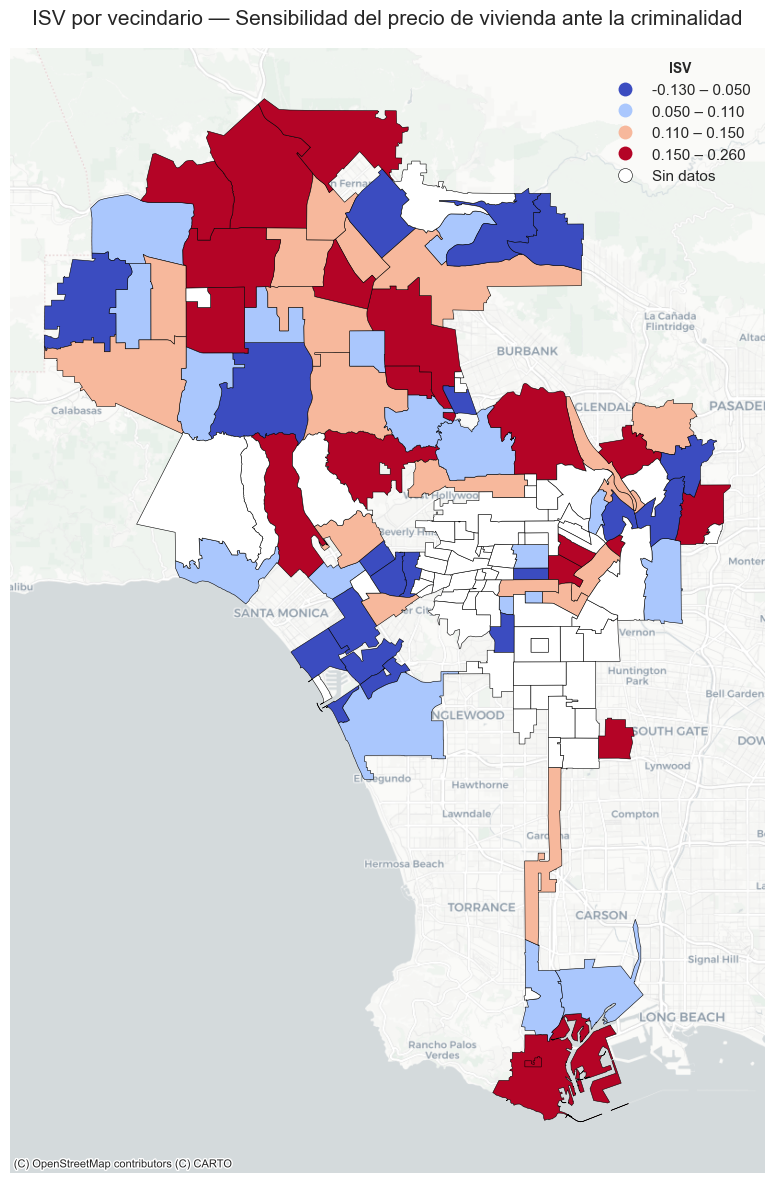

In [121]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import mapclassify


# Cargar GeoJSON de vecindarios
geojson_url = "https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/eva_pereira_lahub_BA_24d4f6a092ee4506/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
vecindarios = gpd.read_file(geojson_url)
vecindarios['neighborhood_clean'] = vecindarios['name'].str.lower().str.strip()

# Unir con los valores de ISV
mapa_isv_cat = vecindarios.merge(
    isv_por_vecindario[['Neighborhood_crimen', 'ISV']].rename(columns={'Neighborhood_crimen': 'neighborhood_clean'}),
    on='neighborhood_clean',
    how='left'
)

# Reproyectar para agregar fondo de mapa
mapa_isv_cat = mapa_isv_cat.to_crs(epsg=3857)

# Crear el mapa categorizado
fig, ax = plt.subplots(figsize=(10, 12))
mapa_isv_cat.plot(
    column='ISV',
    cmap='coolwarm',
    scheme='Quantiles',
    k=4,
    legend=True,
    edgecolor='black',
    linewidth=0.4,
    missing_kwds={
        'color': 'white',
        'edgecolor': 'black',
        'label': 'Sin datos'
    },
    ax=ax
)

# Estilizar leyenda
leg = ax.get_legend()
if leg:
    leg.set_title("ISV", prop={'size': 10, 'weight': 'bold'})
    for text in leg.get_texts():
        txt = text.get_text()
        if "," in txt:
            left, right = txt.replace("(", "").replace("]", "").split(",")
            text.set_text(f"{float(left):.3f} – {float(right):.3f}")

# Fondo de mapa base
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Título y formato
ax.set_title("ISV por vecindario — Sensibilidad del precio de vivienda ante la criminalidad", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()


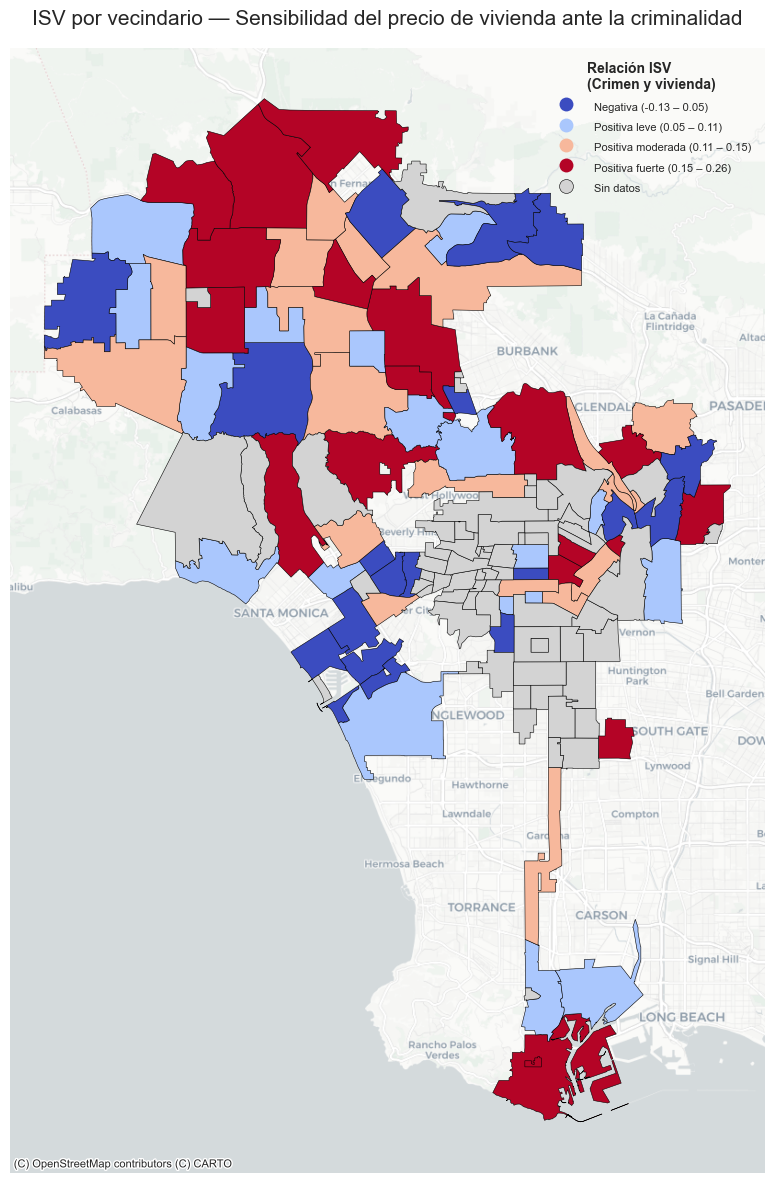

In [122]:
# Cargar GeoJSON de vecindarios
geojson_url = "https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/eva_pereira_lahub_BA_24d4f6a092ee4506/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
vecindarios = gpd.read_file(geojson_url)
vecindarios['neighborhood_clean'] = vecindarios['name'].str.lower().str.strip()

# Unir con los valores de ISV
mapa_isv_cat = vecindarios.merge(
    isv_por_vecindario[['Neighborhood_crimen', 'ISV']].rename(columns={'Neighborhood_crimen': 'neighborhood_clean'}),
    on='neighborhood_clean',
    how='left'
)

# Reproyectar para agregar fondo de mapa
mapa_isv_cat = mapa_isv_cat.to_crs(epsg=3857)

# Crear el mapa categorizado
fig, ax = plt.subplots(figsize=(10, 12))
mapa_isv_cat.plot(
    column='ISV',
    cmap='coolwarm',
    scheme='Quantiles',
    k=4,
    legend=True,
    edgecolor='black',
    linewidth=0.4,
    missing_kwds={
        'color': 'lightgrey',
        'edgecolor': 'black',
        'label': 'Sin datos'
    },
    ax=ax
)

# Etiquetas cualitativas para los 4 rangos
etiquetas = [
    "Negativa",
    "Positiva leve",
    "Positiva moderada",
    "Positiva fuerte"
]

# Estilizar leyenda con texto explicativo + rango real
leg = ax.get_legend()
if leg:
    leg.set_title("Relación ISV\n(Crimen y vivienda)", prop={'size': 10, 'weight': 'bold'})
    textos = leg.get_texts()

    for idx, text in enumerate(textos):
        etiqueta = text.get_text().strip().replace("(", "").replace("]", "")
        if "," in etiqueta:
            izq, der = etiqueta.split(",")
            nuevo = f"{etiquetas[idx]} ({float(izq):.2f} – {float(der):.2f})"
            text.set_text(nuevo)
        elif "Sin datos" in etiqueta:
            text.set_text("Sin datos")

    for text in textos:
        text.set_fontsize(8)

# Fondo de mapa base
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Título final
ax.set_title("ISV por vecindario — Sensibilidad del precio de vivienda ante la criminalidad", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()


### Mapa — ISV por vecindario  
**Sensibilidad del precio de vivienda ante la criminalidad**

Este mapa representa la correlación entre el cambio mensual en la criminalidad y el cambio mensual en el precio de la vivienda a nivel de vecindario. La variable **ISV** (Índice de Sensibilidad del Valor inmobiliario a la criminalidad) ha sido categorizada para facilitar la interpretación:

- `Rojo oscuro:` relación positiva fuerte — en estos vecindarios, un aumento en el crimen se ha asociado con un **aumento significativo** en los precios de vivienda.  
- `Rojo claro:` relación positiva moderada — el crimen se asocia con un **ligero aumento** en el precio.  
- `Azul claro:` relación positiva leve o cercana a cero — el crimen tiene **muy poca influencia directa** en el precio de la vivienda.  
- `Azul oscuro:` relación negativa — un aumento en el crimen está correlacionado con una **disminución del precio de vivienda**.  
- `Gris`: sin datos suficientes.

**General:**  
La relación entre crimen y valor inmobiliario **no es homogénea**. Algunas zonas presentan una resiliencia inesperada (valores positivos), posiblemente por gentrificación u otros factores estructurales, mientras que otras confirman la expectativa de que el crimen reduce el valor del inmueble. Esta visualización subraya la importancia de **políticas urbanas diferenciadas por zona**.


### Mapa interactivo sin categorizar
#### Mapa — ISV por Vecindario

Este mapa muestra la **sensibilidad del precio de vivienda ante cambios en la criminalidad** en cada vecindario de Los Ángeles.

- **Rojo**: correlación positiva — más crimen se asocia con aumento de precios.
- **Azul**: correlación negativa — más crimen se asocia con caída de precios.
- **Gris**: sin datos suficientes para calcular la correlación.

El valor del **ISV** varía significativamente entre zonas, lo que destaca la importancia de un análisis **localizado**. Algunas áreas parecen ser resilientes ante el crimen en términos inmobiliarios, mientras que otras se ven más afectadas.


In [129]:
import folium
import json
import branca.colormap as cm

# Asegurarse de que esté en EPSG:4326 para web mapping
mapa_isv = mapa_isv.to_crs(epsg=4326)

# Crear mapa base centrado en LA
m = folium.Map(location=[34.05, -118.25], zoom_start=10, tiles="CartoDB positron")

# Crear color map
min_isv = mapa_isv['ISV'].min()
max_isv = mapa_isv['ISV'].max()
colormap = cm.LinearColormap(colors=['blue', 'white', 'red'], vmin=min_isv, vmax=max_isv)
colormap.caption = "ISV — Sensibilidad del valor de vivienda a la criminalidad"

# Añadir capa de polígonos
folium.GeoJson(
    data=json.loads(mapa_isv.to_json()),
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['ISV']) if feature['properties']['ISV'] is not None else 'lightgray',
        'color': 'white',
        'weight': 0.5,
        'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(fields=['Neighborhood_clean', 'ISV'],
                                aliases=['Vecindario:', 'ISV:'],
                                localize=True)
).add_to(m)

# Añadir la leyenda
colormap.add_to(m)

# Mostrar el mapa
m.save('../data/ISV_mapa_interactivo_kpi3.html')
m



`Conclusiones finales para este KPI: ISV`

- El ISV global (0.073) indica una relación débil pero estadísticamente significativa entre los cambios mensuales en la criminalidad y los precios de vivienda.

- En general, los precios inmobiliarios no reaccionan de forma fuerte ni uniforme ante cambios en el crimen.

- Sin embargo, algunos vecindarios sí presentan sensibilidad clara, tanto positiva (posible gentrificación) como negativa (desvalorización por inseguridad).

- El análisis confirma que los efectos del crimen sobre el mercado inmobiliario deben analizarse a escala local, considerando el contexto socioeconómico de cada zona.

## KPI 4 — Índice de la Influencia de la Madurez Comercial para la Estabilidad Habitacional (IMCEH)

### Objetivo

Este indicador busca evaluar si existe una relación entre la **edad promedio de los negocios** en un vecindario y el **precio actual de la vivienda**. La hipótesis es que una **mayor madurez comercial** (negocios establecidos desde hace tiempo) puede estar asociada a mayor estabilidad económica y, por lo tanto, a un **valor inmobiliario más alto**.

---

### Fórmulas

**Edad promedio de los negocios:**

$$ \text{Edad}_{b} = \frac{\text{hoy} - \text{fecha\_inicio}}{365} $$

Donde:

- \( $\text{Edad}_{b}$ \): Edad (en años) de cada negocio activo en el vecindario.
- Se considera la fecha actual y la fecha de inicio del negocio.

Luego, se construyen los vectores:

- \( $\hat{E}_n = (\text{Edad}_1, \text{Edad}_2, ..., \text{Edad}_k)$ \): Edad promedio de negocios por vecindario.
- \( $\hat{V}_n = (P_{v_1}, P_{v_2}, ..., P_{v_k})$ \): Precio de vivienda por vecindario.

La fórmula final del KPI es:

$$ \text{IMCEH} = \text{Corr}(\hat{E}_n, \hat{V}_n) $$

---

### Lógica de implementación

1. **Filtrar negocios activos** (sin `fecha_end` o `fecha_end` nula).
2. Calcular la **edad en años** de cada negocio: `(hoy - fecha_inicio) / 365`.
3. Calcular la **edad promedio por vecindario**.
4. Obtener el **precio de vivienda más reciente** por vecindario (`inmu`).
5. Unir ambos DataFrames por vecindario.
6. Calcular la **correlación de Pearson** entre edad promedio de negocios y precio de vivienda (`scipy.stats.pearsonr` o `np.corrcoef`).

---

### Interpretación esperada

- Un **IMCEH positivo** indica que **mayor edad de negocios** está relacionada con **mayores precios de vivienda**, lo que podría reflejar estabilidad o reputación histórica del vecindario.
- Un **IMCEH negativo** sugiere que **vecindarios con negocios más antiguos tienen precios de vivienda más bajos**, lo que podría indicar envejecimiento económico o menor renovación urbana.
- Un **IMCEH cercano a 0** implica **falta de relación directa** entre las variables.


IMCEH (correlación): 0.315 — p-valor: 0.004


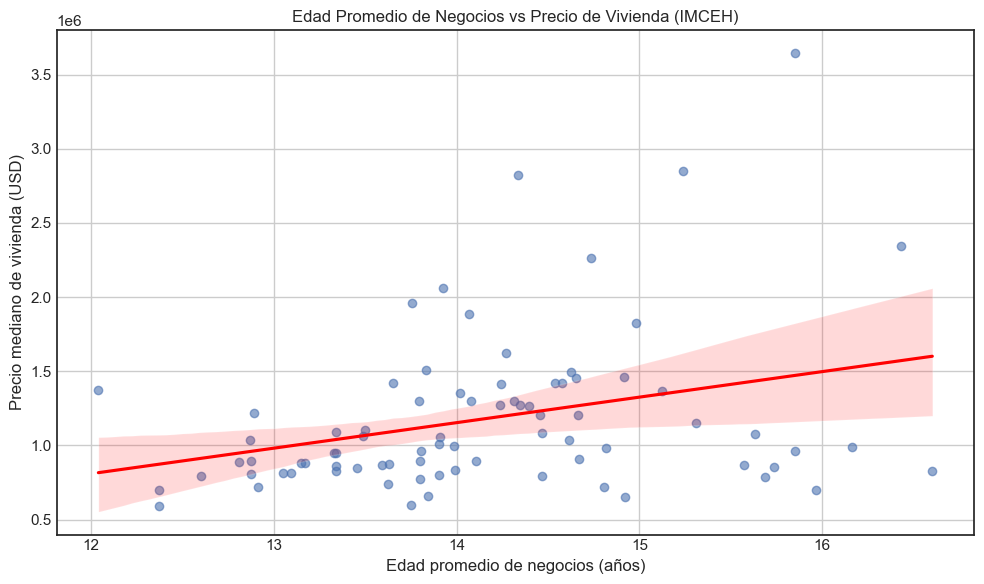

In [124]:
# ===========================
# 1. Calcular edad de negocios activos
# ===========================

# Asegurar fechas en formato datetime
business['LOCATION START DATE'] = pd.to_datetime(business['LOCATION START DATE'], errors='coerce')
business['LOCATION END DATE'] = pd.to_datetime(business['LOCATION END DATE'], errors='coerce')

# Filtrar negocios activos (sin fecha de cierre)
negocios_activos = business[business['LOCATION END DATE'].isna()].copy()

# Calcular edad en años desde su apertura hasta hoy
hoy = pd.to_datetime("today")
negocios_activos['edad_negocio'] = (hoy - negocios_activos['LOCATION START DATE']).dt.days / 365

# Limpiar nombre de vecindario
negocios_activos['neighborhood_clean'] = negocios_activos['neighborhoods'].str.lower().str.strip()

# ===========================
# 2. Edad promedio por vecindario
# ===========================

edad_promedio = (
    negocios_activos
    .groupby('neighborhood_clean')['edad_negocio']
    .mean()
    .reset_index()
    .rename(columns={'edad_negocio': 'edad_promedio_negocios'})
)

# ===========================
# 3. Precio de vivienda más reciente por vecindario
# ===========================

# Asegurar formato de fecha
inmu['date'] = pd.to_datetime(inmu['date'])
inmu['RegionName_clean'] = inmu['RegionName'].str.lower().str.strip()

# Obtener la última observación por vecindario
precio_actual = (
    inmu.sort_values('date')
        .groupby('RegionName_clean')
        .tail(1)[['RegionName_clean', 'Price']]
)

# ===========================
# 4. Unir datasets
# ===========================

imceh_df = edad_promedio.merge(
    precio_actual,
    left_on='neighborhood_clean',
    right_on='RegionName_clean',
    how='inner'
)

# ===========================
# 5. Calcular correlación (IMCEH)
# ===========================

imceh_valor, p_valor = pearsonr(
    imceh_df['edad_promedio_negocios'],
    imceh_df['Price']
)

print(f"IMCEH (correlación): {imceh_valor:.3f} — p-valor: {p_valor:.3f}")

# ===========================
# 6. Gráfico de dispersión
# ===========================

plt.figure(figsize=(10, 6))
sns.regplot(
    data=imceh_df,
    x='edad_promedio_negocios',
    y='Price',
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.title('Edad Promedio de Negocios vs Precio de Vivienda (IMCEH)')
plt.xlabel('Edad promedio de negocios (años)')
plt.ylabel('Precio mediano de vivienda (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()


### Observaciones

- **IMCEH (correlación):** 0.315  
- **p-valor:** 0.004

> *Existe una correlación positiva y estadísticamente significativa entre la edad promedio de los negocios y el precio mediano de vivienda en los vecindarios de Los Ángeles.*

- La correlación positiva sugiere que **vecindarios con negocios más antiguos tienden a tener precios de vivienda más altos**.
- Esto puede reflejar **mayor madurez y estabilidad económica** en zonas donde los negocios llevan más tiempo establecidos.
- Si bien no implica causalidad, esta relación es **estadísticamente significativa**, lo cual respalda su uso como un posible indicador socioeconómico.

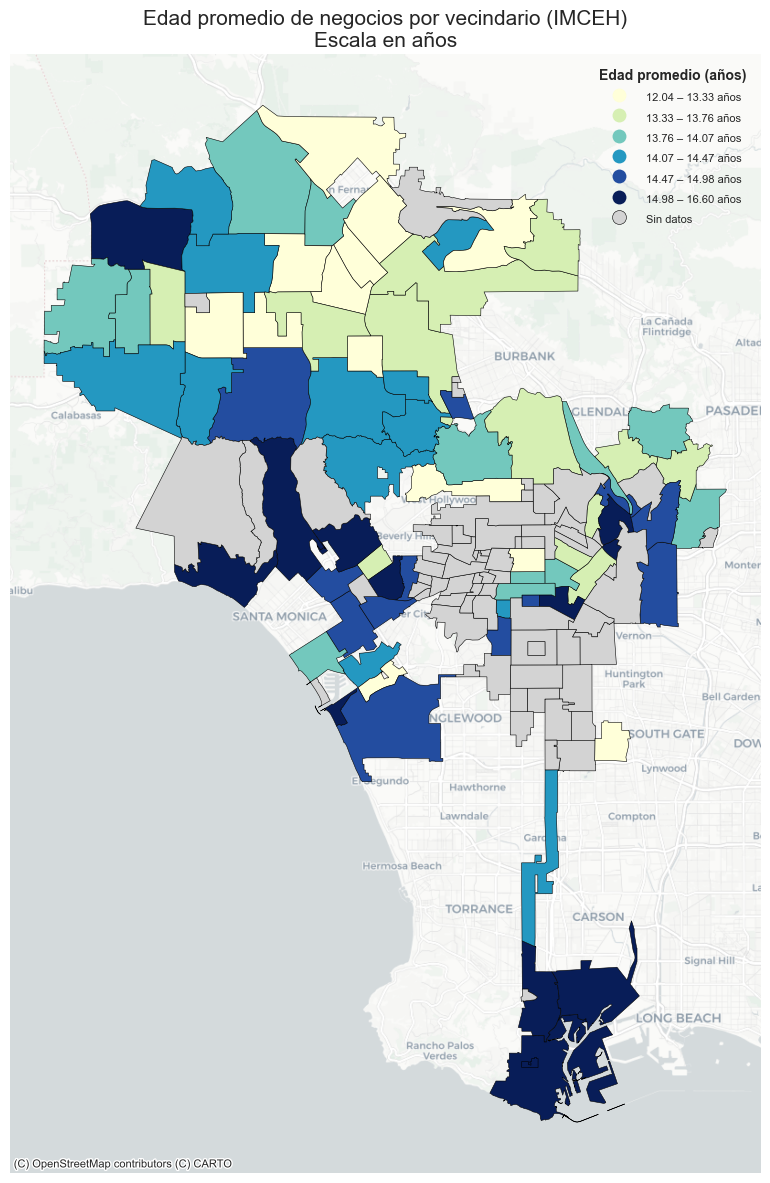

<Figure size 640x480 with 0 Axes>

In [125]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import mapclassify

# Cargar GeoJSON de vecindarios
geojson_url = "https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/eva_pereira_lahub_BA_24d4f6a092ee4506/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
vecindarios = gpd.read_file(geojson_url)
vecindarios['neighborhood_clean'] = vecindarios['name'].str.lower().str.strip()

# Unir con edad promedio de negocios (tu DataFrame real debe llamarse `imceh_df`)
mapa = vecindarios.merge(imceh_df[['neighborhood_clean', 'edad_promedio_negocios']], on='neighborhood_clean', how='left')

# Reproyectar para agregar fondo de mapa
mapa = mapa.to_crs(epsg=3857)

# Crear mapa
fig, ax = plt.subplots(figsize=(10, 12))
mapa.plot(
    column='edad_promedio_negocios',
    cmap='YlGnBu',
    scheme='Quantiles',
    k=6,
    legend=True,
    edgecolor='black',
    linewidth=0.4,
    missing_kwds={
        'color': 'lightgrey',
        'edgecolor': 'black',
        'hatch': '',
        'label': 'Sin datos'
    },
    ax=ax
)

leg = ax.get_legend()
if leg:
    leg.set_title("Edad promedio (años)", prop={'size': 12})
    for text in leg.get_texts():
        txt = text.get_text()
        if "," in txt:
            left, right = txt.replace("(", "").replace("]", "").split(",")
            text.set_text(f"{float(left):.2f} – {float(right):.2f} años")

# Estilizar leyenda
legend = ax.get_legend()
legend.set_title("Edad promedio (años)", prop={'size': 10, 'weight': 'bold'})
for text in legend.get_texts():
    text.set_fontsize(8)
    
    
# Agregar fondo de mapa
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Títulos
ax.set_title("Edad promedio de negocios por vecindario (IMCEH)\nEscala en años", fontsize=15)
ax.axis("off")
#fig.text(0.01, 0.02, "Fuente: OpenStreetMap + Business Dataset (L.A.)", fontsize=9, color='gray')

plt.tight_layout()
plt.show()


plt.savefig("../data/imceh_map_kpi4.png", dpi=300, bbox_inches='tight')


#### 2. Mapa: Edad promedio de negocios por vecindario (IMCEH)  

El mapa permite **identificar zonas con negocios más longevos**, las cuales tienden a ubicarse en regiones con infraestructura más desarrollada y posiblemente con mayor estabilidad residencial.

### Mapa interactivo

In [126]:
import folium
from folium import Choropleth
import geopandas as gpd

# Convertir a GeoJSON y asegurar CRS WGS84
mapa_wgs84 = mapa.to_crs(epsg=4326)

# Crear el mapa base
m = folium.Map(location=[34.05, -118.25], zoom_start=10, tiles='CartoDB positron')

# Añadir capa de choropleth
Choropleth(
    geo_data=mapa_wgs84,
    data=mapa_wgs84,
    columns=['neighborhood_clean', 'edad_promedio_negocios'],
    key_on='feature.properties.neighborhood_clean',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Edad promedio de negocios (años)',
    nan_fill_color='lightgrey'
).add_to(m)

# Mostrar
m.save('../data/imceh_mapa_interactivo_kpi4.html')
m




### Conclusión

El IMCEH proporciona una métrica relevante para explorar la **estabilidad económica a nivel barrial**, ya que revela una relación positiva entre la **madurez comercial** y el **valor inmobiliario**. Este KPI puede ser útil para tomadores de decisiones urbanas o inversionistas que busquen entender patrones de consolidación comercial y su posible impacto en los precios de vivienda.